In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc21 = nn.Linear(300, latent_dim)  
        self.fc22 = nn.Linear(300, latent_dim)  
        self.fc3 = nn.Linear(latent_dim, 300)
        self.fc4 = nn.Linear(300, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [9]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae = VAE().to('cuda')
optimizer = optim.Adam(vae.parameters(), lr=1e-4)


Epoch 1, Loss: 261.7154518229167
Epoch 2, Loss: 200.56286546223959
Epoch 3, Loss: 191.02316223958334
Epoch 4, Loss: 185.55962376302082
Epoch 5, Loss: 181.57366956380207
Epoch 6, Loss: 178.41760100911458
Epoch 7, Loss: 175.83320162760415
Epoch 8, Loss: 173.68833069661457
Epoch 9, Loss: 171.93781180013022
Epoch 10, Loss: 170.38214788411457
Epoch 11, Loss: 169.07230193684896
Epoch 12, Loss: 167.98491735026042
Epoch 13, Loss: 167.02969982096354
Epoch 14, Loss: 166.27796645507811
Epoch 15, Loss: 165.67340708007814
Epoch 16, Loss: 165.08193400065105
Epoch 17, Loss: 164.6058207845052
Epoch 18, Loss: 164.19820325520834
Epoch 19, Loss: 163.7584054361979
Epoch 20, Loss: 163.4445908528646
Epoch 21, Loss: 163.07995081380207
Epoch 22, Loss: 162.76523649088543
Epoch 23, Loss: 162.47018813476564
Epoch 24, Loss: 162.17346106770833
Epoch 25, Loss: 161.8565462076823
Epoch 26, Loss: 161.61029357096353
Epoch 27, Loss: 161.30930208333334
Epoch 28, Loss: 161.0482694824219
Epoch 29, Loss: 160.8010454264323
E

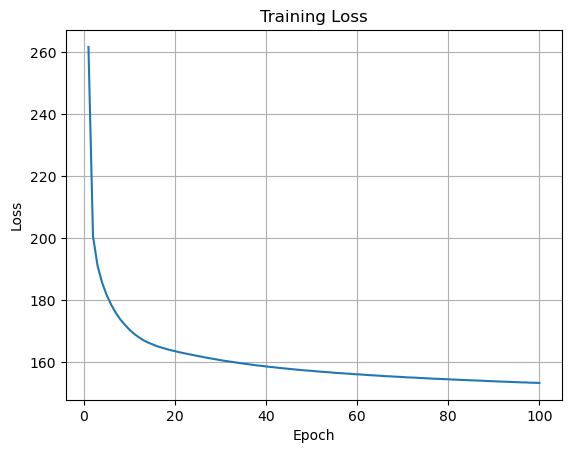

In [10]:
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to('cuda')
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(train_dataset)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss}')


plt.plot(range(1, num_epochs + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()


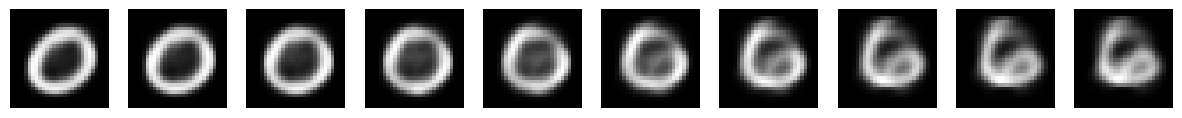

In [14]:
def interpolate_latent_space(model, start, end, steps=15):
    z_values = torch.stack([start * (1 - t) + end * t for t in np.linspace(0, 1, steps)])
    with torch.no_grad():
        interpolated_images = model.decode(z_values).view(-1, 1, 28, 28).cpu()
    return interpolated_images

point_a = torch.randn(2).to('cuda')
point_b = torch.randn(2).to('cuda')
interpolated_images = interpolate_latent_space(vae, point_a, point_b)

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()
